# Diabetes - Model Evaluation 

In this exercise you will train your skills in evaluating a classification model. 

You will focus on a binary problem to identify patients with diabetes. In this task, you have to create a baseline model and compare it with a logistic regression model.

To do so, you will have to choose the best metric for the task. Then, improve the model score with feature selection. 

Be sure that you use the hold out and cross validation method to evaluate generalization. At the end, use the learning curves to evaluate your best model

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

import scikitplot as skplt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report

from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import learning_curve

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

from sklearn.inspection import permutation_importance
#import warnings
#warnings.simplefilter(action="ignore")

# Exploratory data analysis

Download the diabetes dataset from kaggle in your local

https://www.kaggle.com/mathchi/diabetes-data-set/download

In [3]:
diabetes_df = pd.read_csv("data/diabetes.csv")
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


How many features do we have?

In [4]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# nous avons 9 features

Is it a cleaned data set? how much data is missing?

In [6]:
missing_values = diabetes_df.isnull().sum()
missing_values_summary = missing_values[missing_values > 0]
missing_values_summary

Series([], dtype: int64)

In [7]:
duplicate_values = diabetes_df.duplicated().sum()
duplicate_values

0

In [8]:
descriptive_stats = diabetes_df.describe()
descriptive_stats

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


How many patients are considered with diabetes ? do we have equal number of healthy and sick patients? 

In [9]:
diabetes_df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [10]:
# 268 patients sont diabétiques, contre 500 qui ne le sont pas

What can you say about outliers? 

In [11]:
columns = list(diabetes_df.columns)

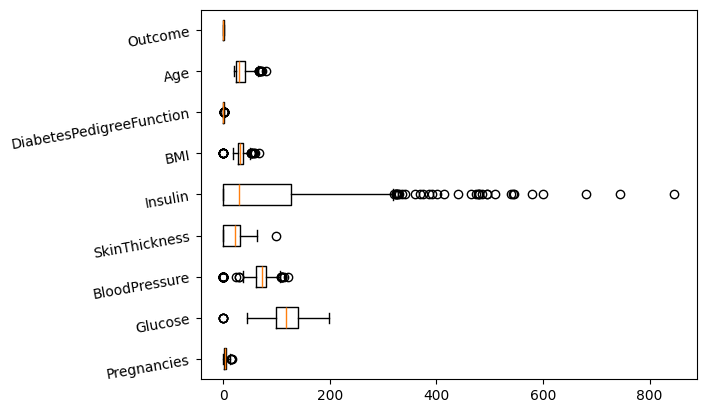

In [12]:
fig, ax = plt.subplots()
ax.boxplot(diabetes_df, vert=0,)
plt.yticks([1, 2, 3, 4,5,6,7,8,9], columns,  rotation = 10)
plt.show()

In [13]:
# Bonus: find a best way to plot individually the boxplots
# any difference

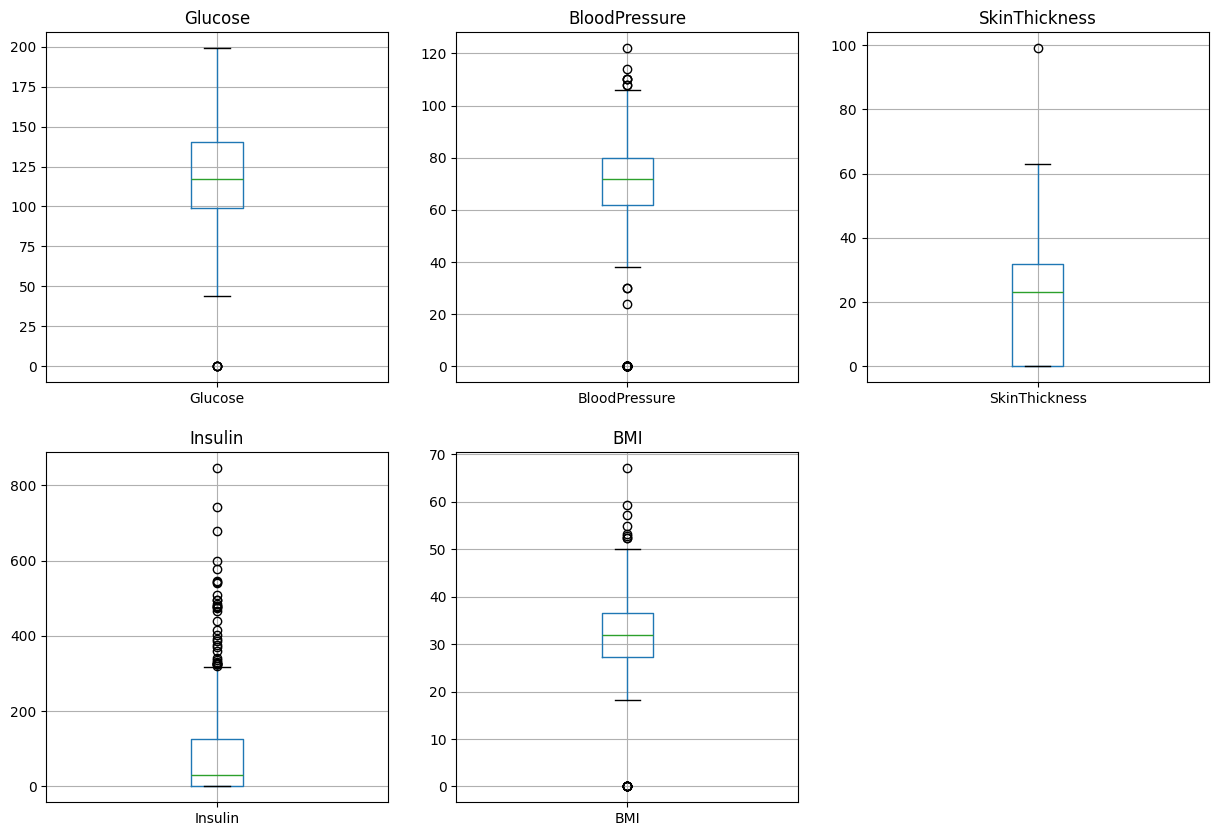

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

boxplot_indiv = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for ax, var in zip(axes.flatten(), boxplot_indiv):
    diabetes_df.boxplot(column=var, ax=ax)
    ax.set_title(var)

axes[1, 2].set_visible(False)

plt.show()

Let's observe the distribution of the dataset. Use a pairplot using a hue with Outcome.

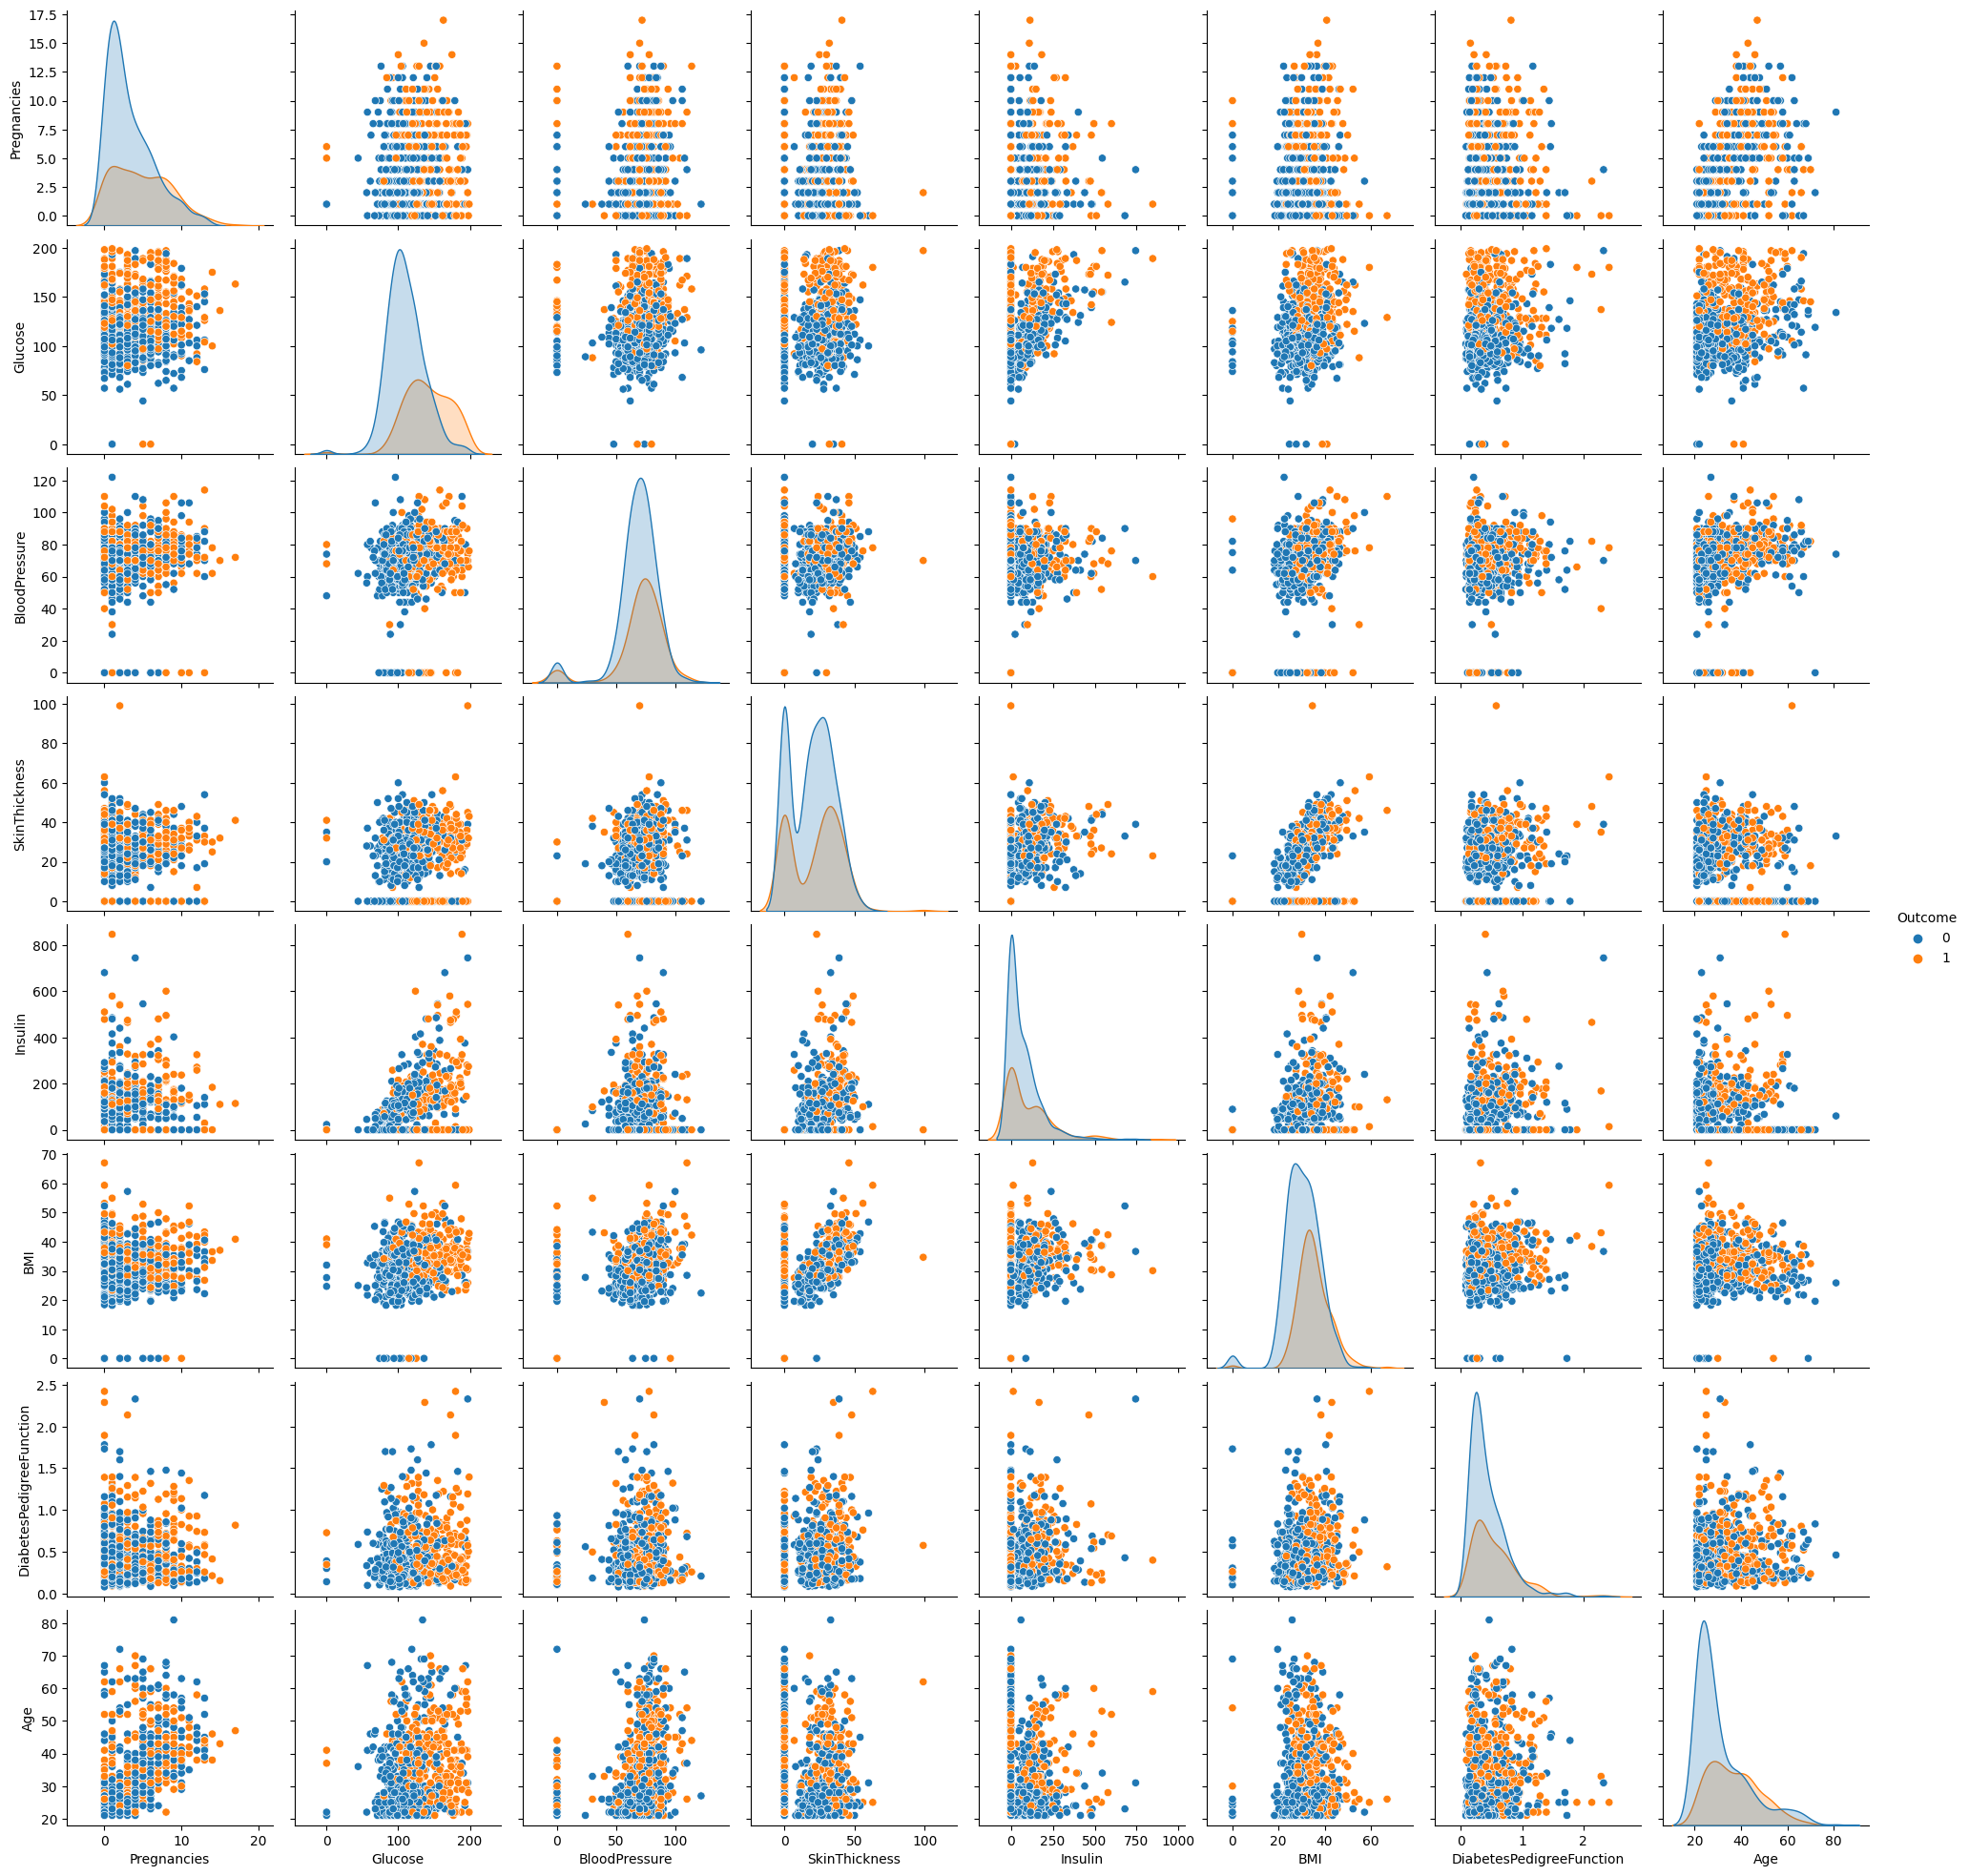

In [15]:
sns.pairplot(data=diabetes_df,hue="Outcome")

is there a feature that let you identify easily the patients with diabetes?

In [16]:
# Glucose

Compare your analysis with a pairgrid. what can you say? are you still ok with the features you selected previously?

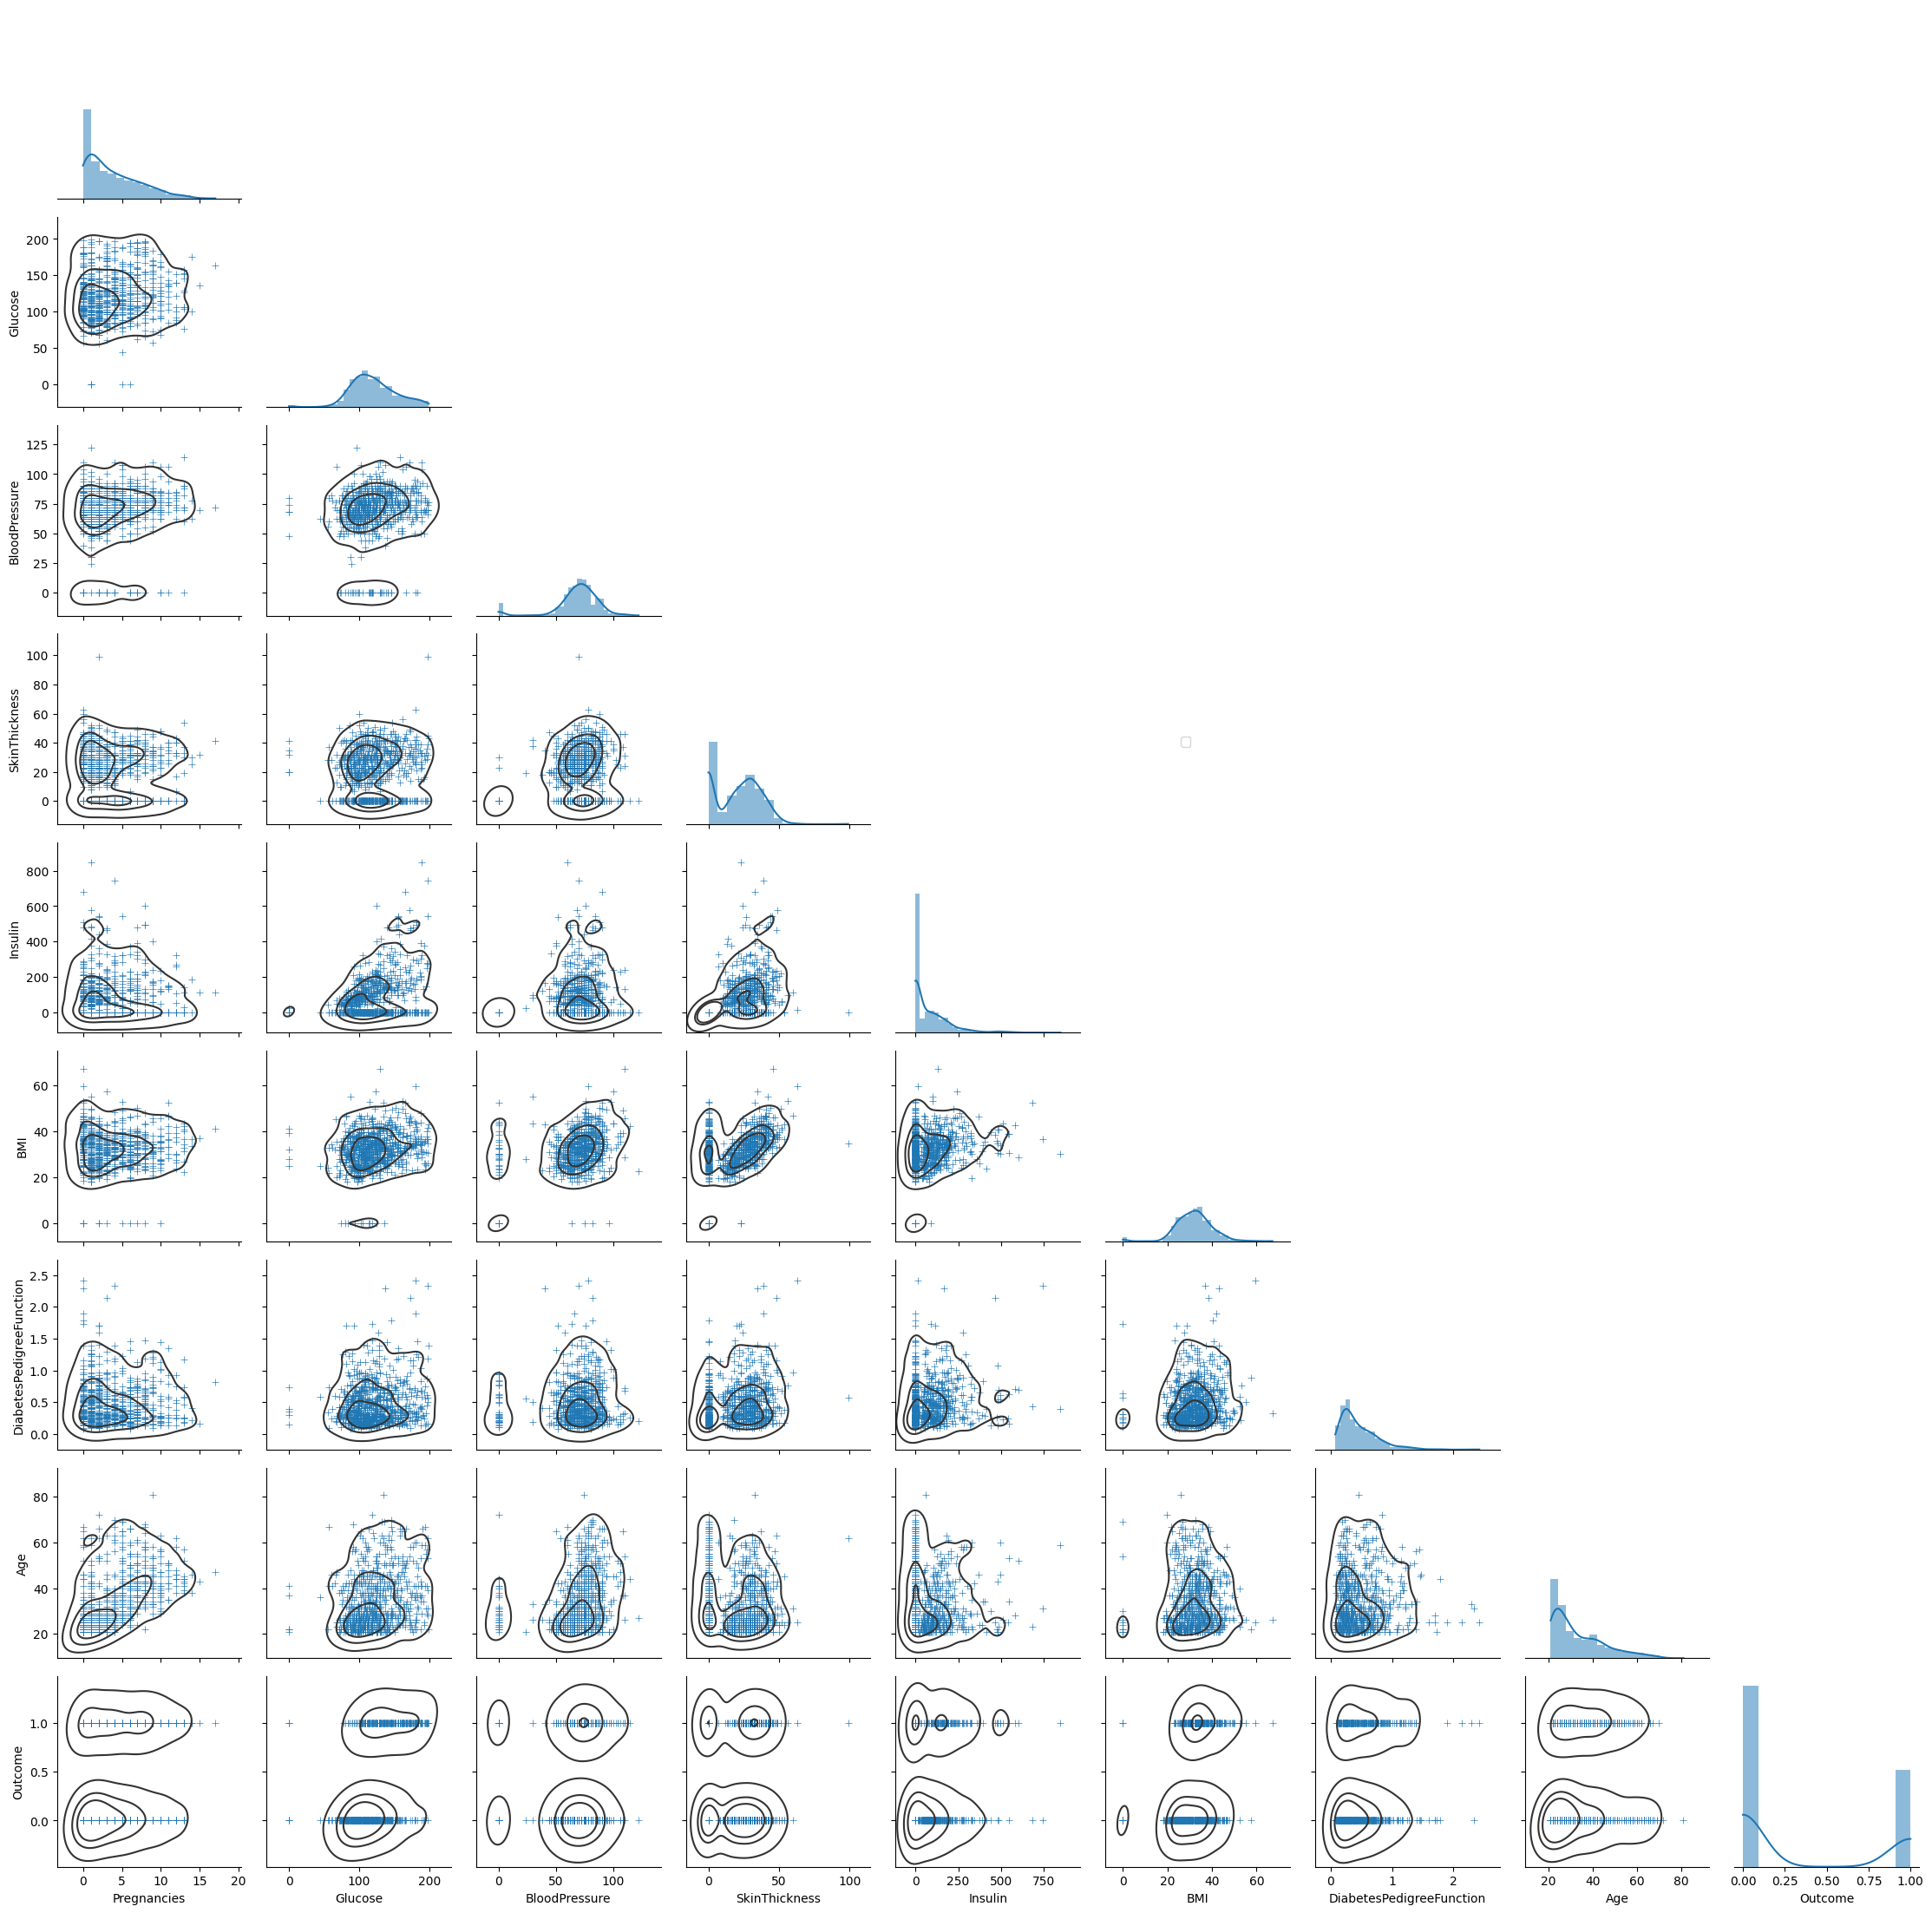

In [17]:
g = sns.PairGrid(data = diabetes_df,corner = True)
g.map_lower(sns.kdeplot, hue = None, levels = 4, color = ".2")
g.map_lower(sns.scatterplot, marker = "+")
g.map_diag(sns.histplot, element = 'step', linewidth=0,kde=True)
g.add_legend(frameon=True)
g.legend.set_bbox_to_anchor((.61,.6))

# Building a baseline model

Let's start building a dummy model using DummyClassifier with strategy "most_frequent". And calculate the score. 

To do so, use all features in X and Outcome as target (y)

In [18]:
# define X, y
y = diabetes_df["Outcome"]
X = diabetes_df.drop("Outcome", axis=1)

In [19]:
# instantiate Dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")

# fit the modem
dummy_clf.fit(X, y)

# calculate the score
dummy_clf.score(X, y)

0.6510416666666666

What are you evaluating? what is the performance metric used by score? Is this a good score? 

In [20]:
# on prédit la donnée la plus commune, donc non diabétique
# le score semble bon

Now let's use the hold out method with the same dummy model. split the date in 70% train and 30% test. Use random_state = 1 for the split

Fit the dummy model with the train and score with the test

In [21]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=1)

In [22]:
dummy_clf = DummyClassifier(strategy="most_frequent")

# fit the modem
dummy_clf.fit(X_train, y_train)

# calculate the score
dummy_clf.score(X_test, y_test)

0.6320346320346321

Is the score better or worst? 

In [23]:
# un peu moins bon

Try to apply the holdout method 2 times more with different random state.

Do you see a difference with the score ?

In [24]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=100)

dummy_clf = DummyClassifier(strategy="most_frequent")

# fit the modem
dummy_clf.fit(X_train, y_train)

# calculate the score
dummy_clf.score(X_test, y_test)

0.6493506493506493

In [25]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=200)

dummy_clf = DummyClassifier(strategy="most_frequent")

# fit the modem
dummy_clf.fit(X_train, y_train)

# calculate the score
dummy_clf.score(X_test, y_test)

0.6883116883116883

In [26]:
# le score n'est pas le même

What is your conclusion? Can we trust the hold out method? why? 

In [27]:
# Le score avec cette méthode varie de plusieurs pourcentage, peut être faudrait il se tourner vers d'autres méthodes pour être plus précis

Let's try to use the cross validate method with dummy model. 

Remember, cross validate don't need to use the train test method. Is going to do it for you several times

In [28]:
# Instanciate model
dummy_clf = DummyClassifier(strategy="most_frequent")

# 5-Fold Cross validate model
cv_results = cross_validate(dummy_clf, X, y, cv=5)

# obtain the mean of scores
cv_results['test_score'].mean()

0.6510482981071216

How many splits did you performed? what represents the parameter cv ?



In [29]:
# 5
# le dataset est divisé en 5 parties

try to see the information in cv_results. What can you say about? 

In [30]:
cv_results

{'fit_time': array([0.00039172, 0.00025105, 0.00023603, 0.00023794, 0.00022912]),
 'score_time': array([0.00030017, 0.0002439 , 0.00023198, 0.00023007, 0.00072718]),
 'test_score': array([0.64935065, 0.64935065, 0.64935065, 0.65359477, 0.65359477])}

In [31]:
# Les temps d'ajustement et de score sont très courts
# Les scores des 5 parties sont très proches

Can you trust more this score ? why ?

In [32]:
# Oui, les différents score sont très proche, bien plus que celui de la holdout method

Congratulations! Now you have your first baseline model :) 



# First Iteration: ML modeling

This time let's perform a logistic regression using all features and compare the result with the dummy model. 

Use the cross validation method 

In [33]:
log_model = LogisticRegression(max_iter=1000)

# 5-Fold Cross validate model
cv_results = cross_validate(log_model, X, y, cv=5)

# obtain the mean of scores
cv_results['test_score'].mean()

0.7721925133689839

Did you improved your baseline score?

In [ ]:
# yes

What do you think is going to happend if you increase cv. Is it going to increase the performance ?

In [ ]:
# oui en théorie

let's find the optimal value for cv

In [54]:
K = []
total_time = []
score = []

for k in range(2,40):
    cross_val_results = cross_validate(log_model, X, y, cv=k)
    total_time.append(sum(cross_val_results['fit_time'])+sum(cross_val_results['score_time']))
    K.append(k)
    score.append(cross_val_results['test_score'].mean())

/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

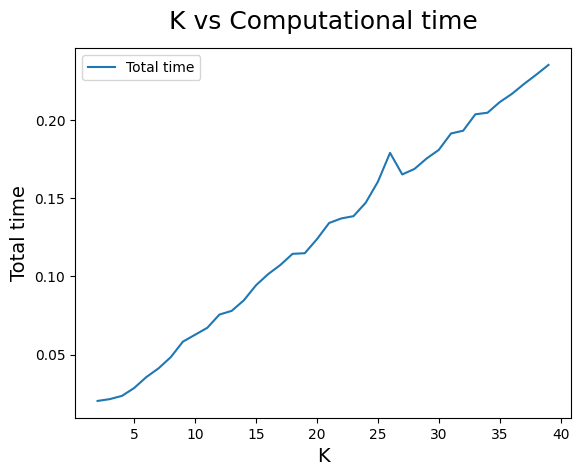

In [55]:
plt.plot(K, total_time, label = 'Total time')
plt.ylabel('Total time', fontsize = 14)
plt.xlabel('K', fontsize = 14)
plt.title('K vs Computational time', fontsize = 18, y = 1.03)
plt.legend()

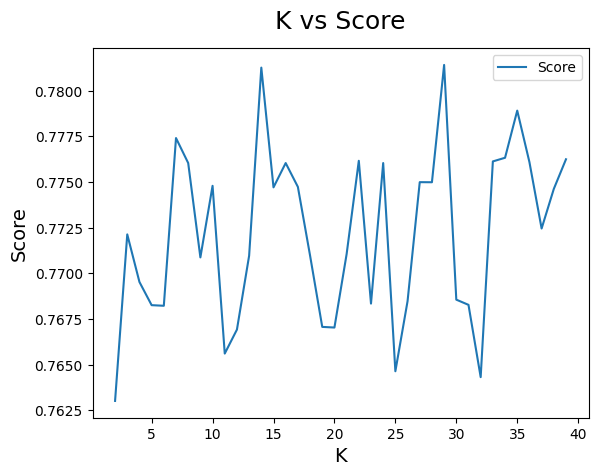

In [56]:
plt.plot(K, score, label = 'Score')
plt.ylabel('Score', fontsize = 14)
plt.xlabel('K', fontsize = 14)
plt.title('K vs Score', fontsize = 18, y = 1.03)
plt.legend()

What is your conclusion? Increasing the cv increases the score? which is the optimal value for the k-fold (cv) considering computational time and scoring?

In [ ]:
# La meilleure valeur est entre 5 et 10, sinon le cout sera trop élevé

Congratulations! You improved your score by changing the model. Let's improve this :) 

# Performance evaluation

In this chapter, we will have to explore the different performance metrics to evaluate our classification task.

To do so, run the following cells. Try to understand what is happening at each step. 

In this chapter we will use the hold out method and cross validation depending what we are trying to achieve. Pay attention on which method is used.

In [57]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=1)

In [62]:
log_model = LogisticRegression()

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

y_prob = log_model.predict_proba(X_test)

log_model.score(X_test,y_test)

/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7835497835497836

What is the utility of using predict_proba instead of predict ?

In [ ]:
# predict_proba permet d'avoir des évalutations plus complexe, notamment avec le AUC-ROC

## Classification metrics

Explore the following metrics. What is the difference between accuracy, recall, precision and f1-score? 

... don't forget to see the imports of libraries to understand where this metrics come from

In [39]:
# Accuracy
accuracy_score(y_test, y_pred)

0.7835497835497836

In [40]:
# Precision
precision_score(y_test, y_pred)

0.7777777777777778

In [41]:
# Recall
recall_score(y_test, y_pred)

0.5764705882352941

In [42]:
# F1
f1_score(y_test, y_pred)

0.6621621621621622

In [ ]:
# On observe une grande différence entre recall / f1 et accurace / precision (ces 2 derniers sont très proche et les plus élevés)

## Classification report

You can have access to all the metrics in one single line using classification report

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       146
           1       0.78      0.58      0.66        85

    accuracy                           0.78       231
   macro avg       0.78      0.74      0.75       231
weighted avg       0.78      0.78      0.78       231



To have access to this data, you have to transform the report into a dictionnary:

In [44]:
report =  classification_report(y_test,y_pred,output_dict=True)
report

{'0': {'precision': 0.7857142857142857,
  'recall': 0.9041095890410958,
  'f1-score': 0.8407643312101911,
  'support': 146.0},
 '1': {'precision': 0.7777777777777778,
  'recall': 0.5764705882352941,
  'f1-score': 0.6621621621621622,
  'support': 85.0},
 'accuracy': 0.7835497835497836,
 'macro avg': {'precision': 0.7817460317460317,
  'recall': 0.7402900886381949,
  'f1-score': 0.7514632466861766,
  'support': 231.0},
 'weighted avg': {'precision': 0.7827939256510684,
  'recall': 0.7835497835497836,
  'f1-score': 0.7750449183570204,
  'support': 231.0}}

How can you collect the f1-score to patients having diabetes? 

In [66]:
f1_score_diabetes = f1_score(y_test, y_pred)
f1_score_diabetes

0.6621621621621622

Among these metrics. Which metric measures the ratio of correct predictions? What is the ratio?

In [ ]:
# Accuracy : 0.78

Among these metrics.  Which metric can flag the patients with risk of diabetes? what is the value? is this good or bad? what happends if this is wrong? is it critical?

In [ ]:
# Recall : 0.58, Le recall mesure la proportion de vrais positifs (patients avec diabète) correctement identifiés par le modèle parmi tous les cas réels positifs (la somme des vrais positifs et des faux négatifs)

Among these metrics. Which metric can measure the pourcentage of patients that can develop diabetes? what happends if this is wrong? is it critical?

In [ ]:
# Recall :

which metric can flag as many patients with diabetes while limiting false alarms? 

In [ ]:
# Score F1

Which is the best metric to measure for this problem (detecting patients with diabetes)?

In [ ]:
# Score F1

## Using cross validation to evaluate different metrics

You can change the metric when performing cross validation. To do so, we use the scoring parameter

In [73]:
# 5-Fold Cross validate model
cv_results = cross_validate(LogisticRegression(max_iter=1000),
                            X, y,
                            cv=5,
                            scoring=['accuracy','recall','precision','f1'])
cv_results

{'fit_time': array([0.02736592, 0.00735283, 0.00713181, 0.00817823, 0.00710511]),
 'score_time': array([0.00464725, 0.00322294, 0.00295925, 0.00283694, 0.0026021 ]),
 'test_accuracy': array([0.77272727, 0.74675325, 0.75324675, 0.81045752, 0.77777778]),
 'test_recall': array([0.59259259, 0.61111111, 0.5       , 0.62264151, 0.54716981]),
 'test_precision': array([0.71111111, 0.64705882, 0.71052632, 0.78571429, 0.74358974]),
 'test_f1': array([0.64646465, 0.62857143, 0.58695652, 0.69473684, 0.63043478])}

Change the following code with the metric you choose before  to obtain the mean score of the different splits?

In [74]:
cv_results['test_recall'].mean()

0.5747030048916841

There is another method called cross_val_score. this is different from the method cross_validate

- cross_val_score: calculate score for each CV split, only one metric 

- cross_validate: calculate one or more scores and timings for each CV split

Run the following cells and write your conclusions

In [75]:
cv_scores = cross_val_score(LogisticRegression(max_iter=1000),
                            X, y,
                            cv=5,
                            scoring='recall')
cv_scores

array([0.59259259, 0.61111111, 0.5       , 0.62264151, 0.54716981])

In [76]:
cv_scores.mean()

0.5747030048916841

Let's use cross validation to calculate the classification report

In [77]:
# get an average prediction for the dataset
y_pred_cv = cross_val_predict(LogisticRegression(max_iter=1000),
                              X, y, cv=5)
y_pred_cv

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,

In [78]:
print(classification_report(y,y_pred_cv))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       500
           1       0.72      0.57      0.64       268

    accuracy                           0.77       768
   macro avg       0.76      0.73      0.74       768
weighted avg       0.77      0.77      0.77       768



How different is this result compared to the classification report obtained with the hold out method? which one is better to evaluate your model ?

There is also a way to get the probabilities of predicting each class with cross val predict

In [79]:
y_prob_cv = cross_val_predict(LogisticRegression(max_iter=1000),
                              X, y, cv=5, method='predict_proba')
y_prob_cv

array([[0.28316672, 0.71683328],
       [0.95587491, 0.04412509],
       [0.17052453, 0.82947547],
       ...,
       [0.83762484, 0.16237516],
       [0.73858382, 0.26141618],
       [0.92589971, 0.07410029]])

In [80]:
y_prob_cv.shape

(768, 2)

This is very important to evaluate the precision-recall tradeoff and the ROC-AUC curve

## confusion matrix

Let's analyse another performance tool. The confusion matrix is useful to evaluate classification models. How do you read this matrix ?

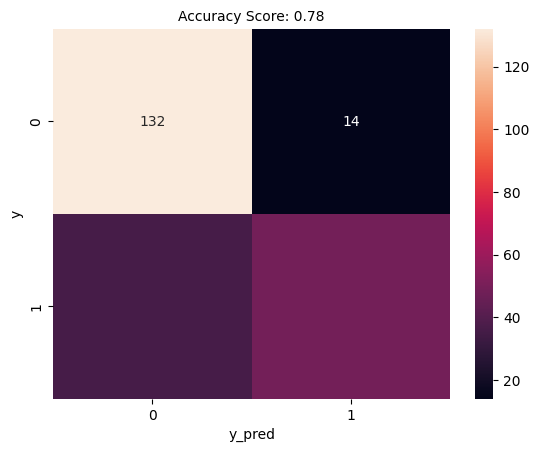

In [81]:
# Confusion Matrix
def plot_confusion_matrix(y, y_pred):
     acc = round(accuracy_score(y, y_pred), 2)
     cm = confusion_matrix(y, y_pred)
     sns.heatmap(cm, annot=True, fmt=".0f")
     plt.xlabel('y_pred')
     plt.ylabel('y')
     plt.title('Accuracy Score: {0}'.format(acc), size=10)
     plt.show()

plot_confusion_matrix(y_test, y_pred)

In [ ]:
# Vrai négatif / Faux positif
# Faux négatif / Vrai positif

What is the difference between of True Positive, True Negative, False Positive and False Negative? What are their values? 

In [ ]:
# Vrai Positif : Cela se produit lorsque le modèle prédit correctement la classe positive. Par exemple, si le modèle prédit qu'un patient a le diabète et que ce patient a effectivement le diabète, c'est un vrai positif.
# Vrai Négatif : Cela se produit lorsque le modèle prédit correctement la classe négative. Par exemple, si le modèle prédit qu'un patient n'a pas le diabète et que le patient n'a effectivement pas le diabète, c'est un vrai négatif.
# Faux Positif : Cela se produit lorsque le modèle prédit incorrectement la classe positive. Par exemple, si le modèle prédit qu'un patient a le diabète mais que le patient ne l'a pas, c'est un faux positif.
# Faux Négatif : Cela se produit lorsque le modèle prédit incorrectement la classe négative. Par exemple, si le modèle prédit qu'un patient n'a pas le diabète mais que le patient a effectivement le diabète, c'est un faux négatif.#

Which of these flags a missing detection? 

In [ ]:
# Faux négatif

Which of these flags a false alarm? 

In [ ]:
# Faux positif

We can use the confusion matrix to calculate accuracy, recall, precision and f1-score. They can be calculated using the values of TP, FN, FP, TN. 

Try to calculate by hand using the cells ... You should find the same values as before

In [ ]:
# accuracy
# accuracy= TP+TN+FP+FN / TP+TN

In [ ]:
# recall of patients with diabetes
# rappel= TP+FN / TP

In [ ]:
# precision
# precision= TP+FN / FP

In [ ]:
# f1-score
# F1=2× Precision+Rappel / Precision×Rappel

In [84]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate Accuracy, Recall, Precision, and F1-Score
accuracy = (tp + tn) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1_score = 2 * (precision * recall) / (precision + recall)

# Output the results
cm, tn, fp, fn, tp, accuracy, recall, precision, f1_score

(array([[132,  14],
        [ 36,  49]]),
 132,
 14,
 36,
 49,
 0.7835497835497836,
 0.5764705882352941,
 0.7777777777777778,
 0.6621621621621621)

## ROC-AUC

Let's see how to use the ROC AUC curve. Run the following cells and answer to the following questions.

we will use the hold out method in this section

In [85]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=1)

In [86]:
log_model = LogisticRegression()

log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

y_prob = log_model.predict_proba(X_test)

log_model.score(X_test,y_test)

/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7835497835497836

In [87]:
# ROC Curve
RocCurveDisplay(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

TypeError: RocCurveDisplay.__init__() takes 1 positional argument but 4 were given

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


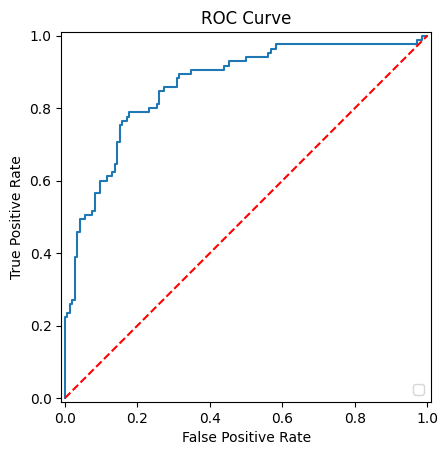

In [88]:
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming log_model is your logistic regression model and it's already fitted.
# Compute probabilities
y_scores = log_model.predict_proba(X_test)[:, 1]  # Get the scores for the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Create ROC Display
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# Customize the plot
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')  # Add diagonal dashed line
plt.show()

In [89]:
# AUC to have diabetes
roc_auc_score(y_test, y_prob[:, 1])

0.8630942788074133

As you can see, the figure is plotted using the TPR and FPR. What are these two values?

In [ ]:
# Vrais positifs et faux positifs

What is the difference between the ROC and the AUC? 

In [ ]:
# La courbe ROC est une représentation graphique, tandis que l'AUC est une mesure numérique

How do you calculate the ROC? don't try to code, just theoretically speaking write your answer

In [ ]:
# Définir seuil de 0 à 1
# Calcul TPR et FPR

How do you calculate the AUC? don't try to code, just theoretically speaking write your answer

In [ ]:
# Calcul avec la Méthode des Trapèzes

The ROC-AUC is used most of the time to compare models. Let's compare the dummy model and the logistic regression using the ROC curve

AUC logistic:  0.8630942788074133
AUC dummy:  0.5


/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


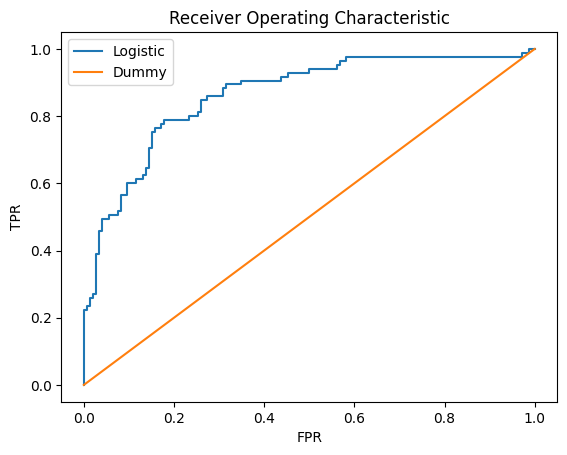

In [90]:
# fit logistic model, get the probabilities, calculate the roc curve
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_log)
AUC_log = roc_auc_score(y_test, y_pred_log)
print("AUC logistic: ", AUC_log)


# fit the dummy model, get the probabilities, calculate the roc curve
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_dummy)
AUC_dummy = roc_auc_score(y_test, y_pred_dummy)
print("AUC dummy: ", AUC_dummy)


plt.plot(fpr1, tpr1, label= "Logistic")
plt.plot(fpr2, tpr2, label= "Dummy")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

What does it mean to have a AUC of 0.5 ?

In [ ]:
# Le modèle fonctionne au hasard

What does it mean to have an AUC higher to 0.5? 

In [ ]:
# Plus précis que le hasard

What does it mean to have an AUC of 1?

In [ ]:
# Precision parfaite

What does it mean to have an AUC lower to 0.5?

In [ ]:
# Pire que le hasard

What does it mean to have an AUC of 0?

In [ ]:
# Toutes les prédictions sont incorrectes

According to you which one is better? dummy or logistic?  why?

In [ ]:
# Logistic car plus précis

Let's try to compare the Logistic model with another model... let's say the KNN model. We will see more about this model soon ;)

AUC logistic:  0.8630942788074133
AUC KNN:  0.7989927477840453


/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


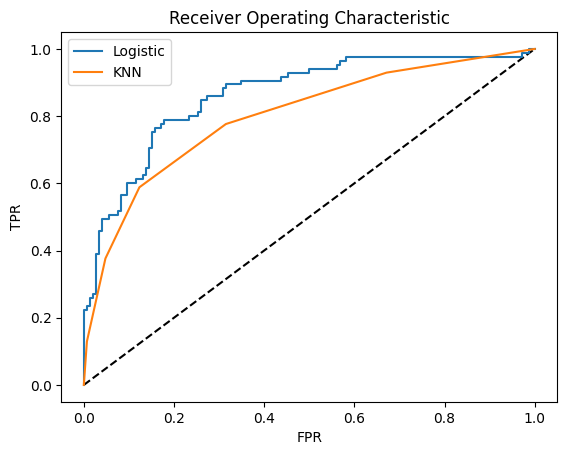

In [91]:
# fit logistic model, get the probabilities, calculate the roc curve
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_log)
AUC_log = roc_auc_score(y_test, y_pred_log)
print("AUC logistic: ", AUC_log)

# fit the KNN model, get the probabilities, calculate the roc curve
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_knn)
AUC_knn = roc_auc_score(y_test, y_pred_knn)
print("AUC KNN: ", AUC_knn)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Logistic")
plt.plot(fpr2, tpr2, label= "KNN")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

Which one is the best classifier model in terms of AUC? knn or logistic? 

## Precision-recall curve

Let's evaluate the tradeoff between the precision and the recall using the precision-recall curve. Run the following cells and answer to the following questions.

we will use the cross val method in this section

In [92]:
# getting all values in one variables
y_prob_cv = cross_val_predict(LogisticRegression(max_iter=1000),
                              X, y, cv=5, method='predict_proba')
y_prob_cv

array([[0.28316672, 0.71683328],
       [0.95587491, 0.04412509],
       [0.17052453, 0.82947547],
       ...,
       [0.83762484, 0.16237516],
       [0.73858382, 0.26141618],
       [0.92589971, 0.07410029]])

In [93]:
y_prob_cv.shape

(768, 2)

In [94]:
# split proba values in two variables
y_pred_prob_cv_0, y_pred_prob_cv_1 = cross_val_predict(LogisticRegression(max_iter=1000),
                              X, y, cv=5, method='predict_proba').T

In [95]:
y_pred_prob_cv_0.shape

(768,)

To evaluate the precision/recall tradeoff, we need to get value of precision and recall depending of the threshold. To do so, we need to  use probabilities for class 1 (diabetes).

Then, we can plot it manually

In [96]:
precision, recall, thresholds = precision_recall_curve(diabetes_df['Outcome'],
                                                       y_pred_prob_cv_1)

In [97]:
# creating a dataframe with recall, precision and threshold
p_r_df = pd.DataFrame({"threshold" : thresholds,
                       "precision" : precision[:-1],
                       "recall" : recall[:-1],
                       })
p_r_df

,threshold,precision,recall
0,0.001643,0.348958,1.000000
1,0.001669,0.349413,1.000000
2,0.003922,0.349869,1.000000
3,0.005885,0.350327,1.000000
4,0.006740,0.350785,1.000000
...,...,...,...
763,0.964489,0.800000,0.014925
764,0.968130,1.000000,0.014925
765,0.969502,1.000000,0.011194
766,0.970663,1.000000,0.007463


Text(0.5, 0, 'recall')

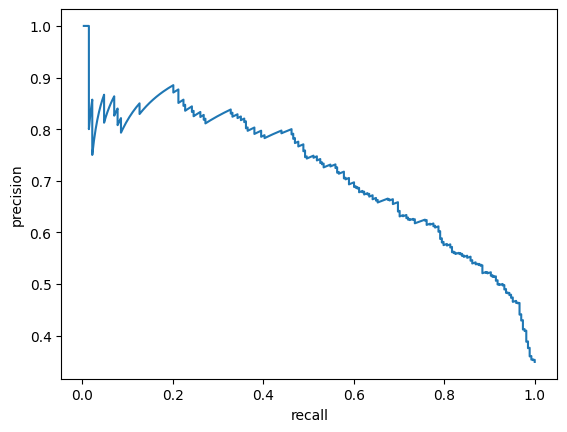

In [98]:
plt.plot(p_r_df['recall'],p_r_df['precision'])
plt.ylabel('precision')
plt.xlabel('recall')

How do you interpret this curve? what is the impact of the threshold on the recall and precision?

In [ ]:
# La courbe chute brusquement au début

We can also calculate the curve using the plot_precision_recall_curve. Note AP stands for average precision. This method is more suited using the hold out method.

In [ ]:
# the plot_precision_recall_curve takes a model trained as parameter
# in order to compare with what we did previously with crossval
# we plot use the whole data set (X,y)
# but keep in mind that we normally plot it with X_test
disp = plot_precision_recall_curve(log_model,
                                   X, y)

disp.ax_.set_title('Precision-Recall curve')

AP is the area under the precision-recall curve. Read more about the Average Precision here,

https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision

Since, we are trying to diagnostic people with diabetes, it would be better to always evaluate the recall. 

Which is the threshold that let us predict patients with a recall of 90% guarantee ? 


In [99]:
new_threshold = p_r_df[p_r_df['recall'] >= 0.9]['threshold'].max()
new_threshold

0.2014994956208282

Let's try to plot this point in the precision recall curve.

In [101]:
# get the value of recall at this threshold
recall_thr = p_r_df[p_r_df['threshold'] == new_threshold]['recall'].iloc[0]

In [102]:
# get the value of precision at this threshold
precision_thr = p_r_df[p_r_df['threshold'] == new_threshold]['precision'].iloc[0]

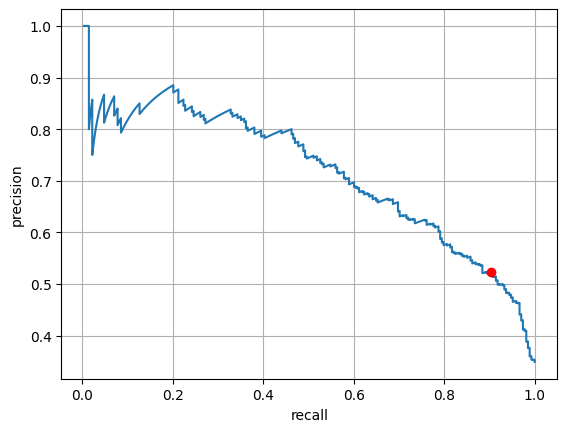

In [103]:
plt.plot(p_r_df['recall'],p_r_df['precision'])
plt.plot(recall_thr, precision_thr, '-ro' )
plt.ylabel('precision')
plt.xlabel('recall')
plt.grid()

## Building your own custom predict

Now that we have our own threshold, we need to use it for future prediction and scoring

Let's create a function custom_predict that takes as parameters the X, the model fitted and the threshold.

Then, it calculates the probabilities and gives the prediction based on the threshold

Remember, cross validate does not train the model (it just evaluate it). So, we can have two solutions: 
1- use the hold out method to train the model and then, use our custom prediction to evaluate probabilities
2- use cross val to calculate probabilities and use the custom prediction 

In [104]:
# Define custom predict function for hold out method
def custom_predict1(model, X, custom_threshold):
    # Get probability of each sample being classified as 0 or 1
    probs = model.predict_proba(X)
    # Only keep probabilities of class [1]
    diabetes_probs = probs[:, 1]
    # return the prediction given the threshold
    return (diabetes_probs > custom_threshold)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=1)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

y_pred_1 = custom_predict1(log_model, X_test, new_threshold)

/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


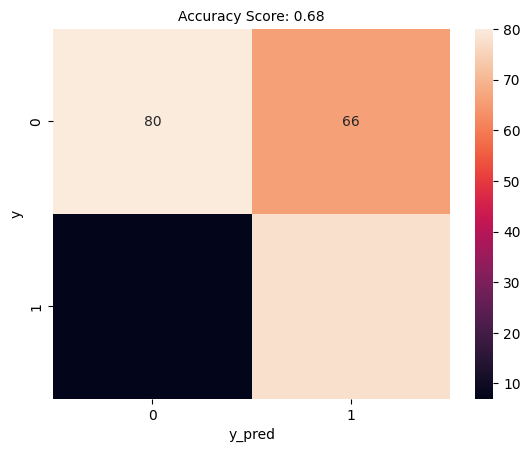

In [106]:
plot_confusion_matrix(y_test, y_pred_1)

In [107]:
# Define custom predict function for cross val
def custom_predict2(model_probs, X, custom_threshold):
    # Only keep probabilities of class [1]
    diabetes_probs = model_probs[:, 1]
    # return the prediction given the threshold
    return (diabetes_probs > custom_threshold).astype('int64')

In [108]:
y_prob_cv = cross_val_predict(LogisticRegression(max_iter=1000),
                              X, y, cv=5, method='predict_proba')

y_pred_2 = custom_predict2(y_prob_cv, X, new_threshold)

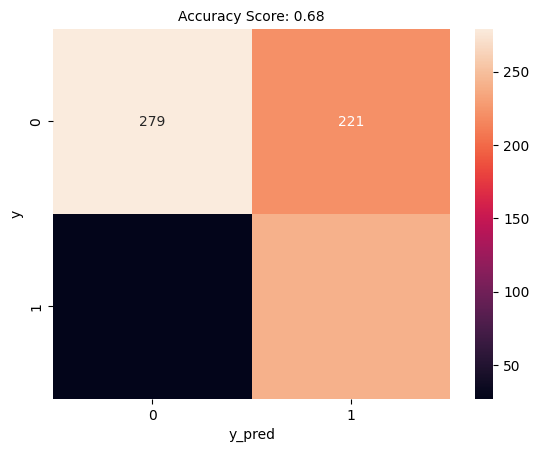

In [109]:
plot_confusion_matrix(y, y_pred_2)

What is your conclusion with the changes ?

In [ ]:
# Les valeurs sont plus élevées avec la validation croisée

# Learning curves

Now, let's evaluate our model capacity to generalize. To do so, we will evaluate the overfitting and underfitting with the learning curves. 

We will use the module learning_curve from scikit learn. Read the documentation to understand what is happening

In [110]:
# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = LogisticRegression(max_iter=1000),
                                          X = X,
                                          y = y,
                                          train_sizes = [5,10,50,100,200,300,400],
                                          cv = 5,
                                          scoring='recall',
                                          shuffle = True,
                                          random_state=3)

According to you, is it necessary to perform the holdout or cross val to see the learning curves? 

In [111]:
# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

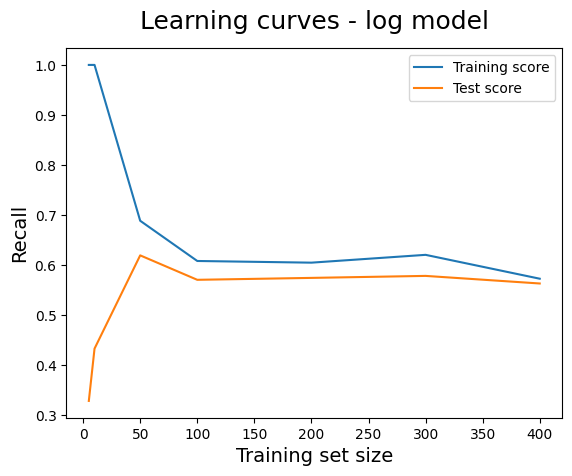

In [112]:
# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('Recall', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves - log model', fontsize = 18, y = 1.03)
plt.legend()
plt.show()

What can you say of the curves?

In [ ]:
# grand écart au début, ce qui signifie que le modèle est trop ajusté aux données d'entraînement
# ensuite les courbes semblent converger, ce qui indique que la performance du modèle sur l'ensemble d'entraînement et de test se stabilise
# Les valeurs de rappel semblent se stabiliser autour de la plage de 0,6 à 0,7 pour l'ensemble de test

How is the biais and the variance? high or low?

In [ ]:
# Biais élevé car entrainé avec peu de données, puis ne rejoint pas les données d'entrainement
# Variance haute au début, puis diminue

Is the model overfitting? underfitting?

In [ ]:
# Surajustement au début, puis légérement sous ajusté

Note, that we are not using the the threshold from the previous section. In order to do that, you should create your own algorithm to calculate the learning curves. Is not hard, but we will not do it this time :) 

# Second Iteration: Feature Selection

Let's recap what you have achieved so far:

- You build a baseline model with a dummy score (65% accuracy) and using all features
- You beat the dummy model with a logistic regression during your first ML iteration using all features. This become your new baseline model (77% accuracy)
- You noticed that the default score (accuracy) is not the best to detect diabetes. So you decided to change the performance metric and the threshold. Your new baseline score (57% recall with a threshold at 0.5)
- You evaluated if your model overfit/underfit and now you have an idea if the logistic regression is a good model for the problem

Now, let's do a second iteration by performing feature selection. Our goal is to find the best features that increases the recall

## Univariate feature selection

Let's evaluate the Pearson correlation of the features

<Axes: >

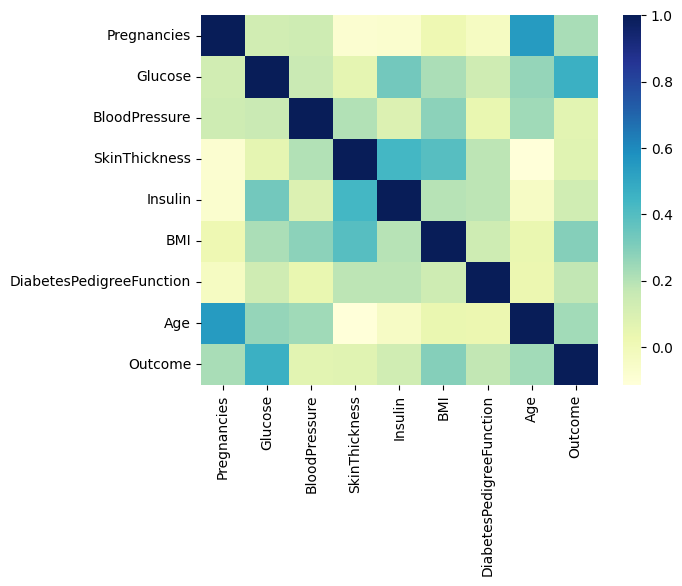

In [113]:
corr = diabetes_df.corr() # Pearson Correlation

# Heatmap
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [114]:
# another way to visualize it
diabetes_df.corr().style.background_gradient(cmap='coolwarm')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


According to this graph, which are the features correlated with the target Outcome?

In [ ]:
# Glucose, BMI

Let's visualize the pairs of correlation numerically

In [115]:
# Unstack correlation matrix
corr_df = corr.unstack().reset_index()
corr_df

# rename columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# sort by correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True)

# Remove self correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']]
corr_df

,feature_1,feature_2,correlation
7,Pregnancies,Age,0.544341
63,Age,Pregnancies,0.544341
17,Glucose,Outcome,0.466581
73,Outcome,Glucose,0.466581
39,Insulin,SkinThickness,0.436783
...,...,...,...
36,Insulin,Pregnancies,-0.073535
3,Pregnancies,SkinThickness,-0.081672
27,SkinThickness,Pregnancies,-0.081672
66,Age,SkinThickness,-0.113970


Now let's evaluate which are the features correlated with the target

In [116]:
diabetes_corr_df = corr_df[corr_df['feature_1'] == 'Outcome']
diabetes_corr_df

,feature_1,feature_2,correlation
73,Outcome,Glucose,0.466581
77,Outcome,BMI,0.292695
79,Outcome,Age,0.238356
72,Outcome,Pregnancies,0.221898
78,Outcome,DiabetesPedigreeFunction,0.173844
76,Outcome,Insulin,0.130548
75,Outcome,SkinThickness,0.074752
74,Outcome,BloodPressure,0.065068


Which is the feature that explains the most the risk of diabetes ?

In [ ]:
# Glucose

Try different features to train logistic regression with cross validation by adding new features (starting with the one with highest correlation

In [124]:
X_eval = X[['Glucose']]

cv_results = cross_validate(LogisticRegression(max_iter=1000),
                            X_eval, y,
                            cv=5,
                            scoring=['recall'])
cv_results['test_recall'].mean()

0.49273235499650586

Which is the best combination you found ? Did you beat the baseline score? 

In [ ]:
# Glucose

## Collinearity investigation

Let's evaluate which features have a risk to show data leakage. 

First, let's see which features present a correlation of 0.9 or higher

In [125]:
correlated_features = len(corr_df[(corr_df['correlation'] >= 0.9) | (corr_df['correlation'] <= -0.9)])

correlated_features

0

How many features seems to have high correlation?

In [ ]:
# 0

Now, we will evaluate the VIF factor to the whole dataframe. To do so, we will use the module variance_inflation_factor from stats_models 

You can read this article to understand more about it : https://en.wikipedia.org/wiki/Variance_inflation_factor

${\displaystyle \mathrm {VIF} _{i}={\frac {1}{1-R_{i}^{2}}}}$

In [126]:
# compute VIF factor for feature index 0
vif(diabetes_df.values, 0)

3.364415864908099

In [127]:
# compute the VIF factor to all the features
# store results in a dataframe
vif_df = pd.DataFrame()
vif_df["vif_index"] = [vif(diabetes_df.values, i) for i in range(diabetes_df.shape[1])]
vif_df["features"] = diabetes_df.columns
vif_df

,vif_index,features
0,3.364416,Pregnancies
1,18.030209,Glucose
2,15.313159,BloodPressure
3,4.008709,SkinThickness
4,2.063940,Insulin
5,18.515112,BMI
6,3.213450,DiabetesPedigreeFunction
7,13.500531,Age
8,1.948398,Outcome


What can you say about the results?

In [ ]:
# Glucose, BMI et BloodPressure sont les plus élevés

there is a big possibility that there is some collinearity between Glucose, BloodPressure and BMI, age. So, we should keep attention to these pairs of features

Let's verify your hypothesis by removing Outcome. The VIF will give you the collinearity between features

In [128]:
vif_df = pd.DataFrame()
vif_df["vif_index"] = [vif(X.values, i) for i in range(X.shape[1])]
vif_df["features"] = X.columns
vif_df

,vif_index,features
0,3.275748,Pregnancies
1,16.725078,Glucose
2,14.619512,BloodPressure
3,4.008696,SkinThickness
4,2.063689,Insulin
5,18.408884,BMI
6,3.195626,DiabetesPedigreeFunction
7,13.492985,Age


What are your conclusions?

In [ ]:
# Elles sont toujours à un score élevé

Try new cross_validate training to observe which feature has the most of information

What is your conclusion?

## Feature Permutation

To finish this exercise, let's perform feature permutation technique. To do so, you will use the hold out method to train your model. then use the test set to use the module permutation_importance

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.3,
                                                    random_state=1)
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

/Users/guillaumedemerges/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [132]:
# Perform Permutation
permutation_score = permutation_importance(log_model,
                                           X_test, y_test,
                                           scoring='recall',
                                           random_state=3,
                                           n_repeats=100)

# Unstack results
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score.importances_mean)).T)

importance_df.columns=['feature','feature importance']

# Order by importance
importance_df.sort_values(by="feature importance", ascending = False)

,feature,feature importance
1,Glucose,0.214235
5,BMI,0.045882
4,Insulin,0.005765
3,SkinThickness,0.005294
7,Age,0.004824
0,Pregnancies,0.003176
2,BloodPressure,-0.005294
6,DiabetesPedigreeFunction,-0.007882


What are you conclusion about the results? Does it confirms your previous choice ?

In [ ]:
# yes le glucose

Try to explain with your own words how feature importance is calculated

We can also visualize the feature importance by using the boxplot. However, it is important to put more attention to the median

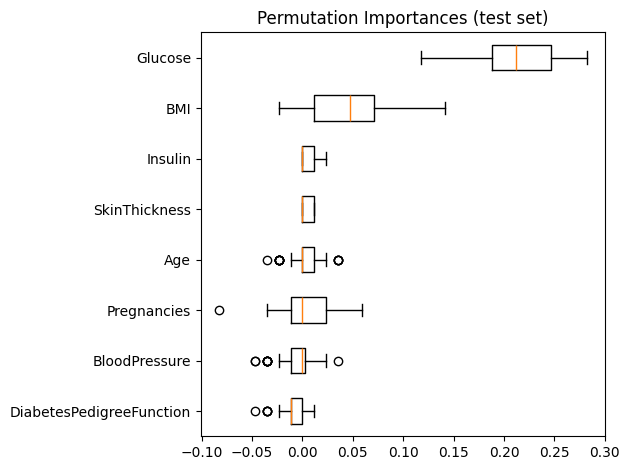

In [133]:
sorted_idx = permutation_score.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(permutation_score.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

How do you interpret this figure?

If you have to select only 3 features which would be your best feature selection? What is the score? 

It is better or worst compared to the previous one? 

🏁 Congratulations !! You have improved your model :)